In [171]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Compra financiada

Calculo da parcela:


$$ P_i = -\left( \frac{V}{n} + \left(V - \frac{V}{n}(i-1)\right)t_j \right) $$

- $P_i$ é a parcela $i$ do aluguel
- $V$ é o valor do imovel
- $n$ é o número de parcelas
- $t_j$ é a taxa de juros do financiamento

$$ \operatorname{VP}[P_i] = \frac{P_i}{(1+t_{r})^i} $$

<!-- 
$$ \operatorname{VP}[P_i] = \sum_{i=1}^{n} \frac{P_i}{(1+t_{r})^i} = - \sum_{i=1}^{n} \left(\frac{V}{n} + \left(V - \frac{V}{n}(i-1)\right)t_j\right)\frac{1}{(1+t_{r})^i}$$ -->

- $t_r$ é a taxa de juros livre de risco 

$$ \operatorname{VP}[Parcelas] = \sum_{i=1}^{n} \frac{P_i}{(1+t_{r})^i} $$

<!-- $$ \operatorname{VP}[P_i] = - V \sum_{i=1}^{n} \frac{1}{n (1+t_{r})^i} + \left(1 - \frac{i-1}{n}\right)\frac{t_j}{(1+t_{r})^i}$$
 -->

<!-- $$ \operatorname{VP}[P_i] = V\left( \sum_{i=1}^{n} \frac{1}{n t_{r}^i} + \sum_{i=1}^{n} \left(1 - \frac{i-1}{n}\right)\frac{t_j}{t_{r}^i}\right)$$
 -->

<!-- Podemos resolver o primeiro somatório como um somatório de uma PG finita:
$$ \sum_{i=1}^{n} \frac{1}{n t_{r}^i} =\frac{ \frac{1}{n t_r} \left (\frac{1}{t_r^n} - 1\right)}{ \frac{1}{t_r} - 1} = \frac{\frac{1}{n} \left(\frac{1}{t_r^n - 1}\right)}{1-t_r}$$  -->

Quanto ao imovel o seu valor futuro é:

$$\operatorname{VF}[Imovel] = V(1+t_i)^n $$

- $t_i$ é a taxa de retorno do mercado imobiliario

Logo o seu valor presente é:

$$\operatorname{VP}[Imovel] = \frac{V(1+t_i)^n}{(1+t_r)^n} $$


O valor presente do investimento considerando a compra financiada é, então:

$$ \operatorname{VP}[Total] = \operatorname{VP}[Parcelas] + \operatorname{VP}[Imovel] $$


<!-- $$ \operatorname{VP}[total] = - V \sum_{i=1}^{n} \left( \frac{1}{n (1+t_{r})^i} + \left(1 - \frac{i-1}{n}\right)\frac{t_j}{(1+t_{r})^i}\right) + \frac{V (1+t_i)^n}{(1+t_r)^n} $$  -->

<!-- $$ \operatorname{VP}[total] = V\left( - \sum_{i=1}^{n} \left( \frac{1}{n (1+t_{r})^i} + \left(1 - \frac{i-1}{n}\right)\frac{t_j}{(1+t_{r})^i}\right) + \frac{(1+t_i)^n}{(1+t_r)^n} \right) $$ -->

Em um determinado momento do tempo, o valor presente do patrimonio é:

$$ \operatorname{VP}[Total]_k = k \frac{V}{n}\frac{(1+t_i)^k}{(1+t_r)^k} + \sum_{i=1}^{k} \frac{P_i}{(1+t_{r})^i}  $$ 

In [187]:
class SistemaDeAmortizacao:
    pass

class SAC(SistemaDeAmortizacao):
    def __init__(self, t_j, n):
        self.t_j = anual_to_month_rate(t_j)
        self.n = n
    
    def parcela(self, V, i):
        if i < 1 or i > self.n:
            return 0
        amortizacao = V/self.n
        valor_amortizado = (V/self.n)*(i-1)
        saldo_anterior = V - valor_amortizado
        juros = saldo_anterior * self.t_j
        return - (amortizacao + juros)
    
    def parcelas(self, V):
        return [self.parcela(V, i) for i in range(self.n + 1)]
    
    def propriedade(self, V, i):
        return V * i / self.n     

In [188]:
import numpy as np

def anual_to_month_rate(rate):
    return (1 + rate)**(1/12) - 1

class Financiamento:
    def __init__(self, V, t_r, t_i, amortizador):
        self.V = V
        self.n = amortizador.n
        self.t_r = anual_to_month_rate(t_r)
        self.t_i = anual_to_month_rate(t_i)
        
        self.amortizador = amortizador
     
    def run_simulation(self):
        self.parcelas = self.amortizador.parcelas(self.V)
        VP_parcelas = np.cumsum([self.valor_presente(parcela, i) 
                       for i, parcela in enumerate(self.parcelas)]).tolist()
        
        VP_imovel = [
            self.valor_presente(
                self.valor_futuro(self.amortizador.propriedade(self.V, i), i, self.t_i), 
                i)
            for i in range(self.n+1)]
        
        VP_total = list(map(sum, zip(VP_parcelas, VP_imovel)))
        return VP_parcelas, VP_imovel, VP_total
    
    def propriedade(self, i):
        return self.V * i / self.n 
    
    def valor_presente(self, valor, periodos, montly_rate=None):
        montly_rate = montly_rate if montly_rate is not None else self.t_r
        return valor/((1 + montly_rate) ** periodos)
    
    def valor_futuro(self, valor, periodos, montly_rate=None):
        montly_rate = montly_rate if montly_rate is not None else self.t_r
        return valor * (1 + montly_rate) ** periodos


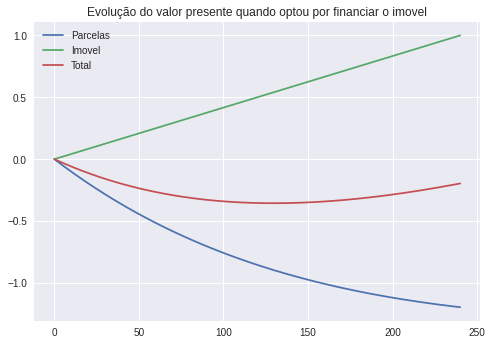

In [201]:
f = Financiamento(V=1, t_r=0.05, t_i=0.05, amortizador=SAC(t_j=0.078, n=12*20))
VP_parcelas, VP_imovel, VP_total = f.run_simulation()
plt.plot(VP_parcelas, label='Parcelas')
plt.plot(VP_imovel, label='Imovel')
plt.plot(VP_total, label='Total')
plt.legend()
plt.title('Evolução do valor presente quando optou por financiar o imovel');

# Aluguel
## Valor do investimento mensal

O valor do investimento mensal que vamos considerar é o que sobrar do aluguel em relação a parcela que seria paga no financiamento.


$$I_i = - P_i - c_a V (1+t_i)^i$$

- $c_a$ é o custo do aluguel mensal reference ao valor do imóvel

Note que o custo do aluguel pode ficar maior que o saldo acumulado dos investimentos (valor futuro na data considerada). Caso isso aconteça o valor futuro dos investimento é zero.

O valor futuro do investimento vai ser:
$$ \operatorname{VF}[I_i] = I_i (1+t_{m})^{n-i}$$

- $ t_m $ é o rendimento do dinheiro aplicado  

Logo o valor presente do investimento é:

$$ \operatorname{VP}[I_i] = \frac{I_i (1+t_{m})^{n-i}}{(1+t_r)^n}  $$

$$ \operatorname{VP}[Investimentos] = \sum_{i=1}^{n} \frac{I_i (1+t_{m})^{n-i}}{(1+t_r)^n}  $$

<!-- ## Valor do aluguel
Ao final do periodo de análise, o individuo terá que continuar pagando aluguel. Esse aluguel corresponde a:

$$A_i = - c_a V (1+t_i)^i$$

Logo seu valor presente é:

$$ \operatorname{VP}[A_i] = - c_a V \frac{(1+t_i)^i}{(1+t_r)^i}  $$
 -->

O valor presente das parcelas continua o mesmo da compra financiada, ou seja:

$$ \operatorname{VP}[Parcelas] = \sum_{i=1}^{n} \frac{P_i}{(1+t_{r})^i} $$


Assim, nessa categoria, o valor presente total é:

$$ \operatorname{VP}[Total] =  \operatorname{VP}[Parcelas] + \operatorname{VP}[Investimentos] $$ 



Em um determinado momento do tempo, o valor presente do patrimonio é:

$$ \operatorname{VP}[Total]_k =  \sum_{i=1}^{k} \frac{P_i}{(1+t_{r})^i}  + \sum_{i=1}^{k} \frac{I_i (1+t_{m})^{k-i}}{(1+t_r)^k}  $$ 


In [195]:
import numpy as np

def anual_to_month_rate(rate):
    return (1 + rate)**(1/12) - 1

class Aluguel:
    def __init__(self, V, c_a, t_r, t_i, t_m, amortizador):
        
        self.V = V
        self.n = amortizador.n
        self.c_a = c_a
        self.t_r = anual_to_month_rate(t_r)
        self.t_i = anual_to_month_rate(t_i)
        self.t_m = anual_to_month_rate(t_m)
        self.amortizador = amortizador
     
    def run_simulation(self):
        self.parcelas = self.amortizador.parcelas(self.V)
        self.investimentos = self.calc_investimentos()
        VP_parcelas = np.cumsum([self.valor_presente(parcela, i) 
                       for i, parcela in enumerate(self.parcelas)]).tolist()
        
        VP_investimentos = [0]
        for _n in range(1, self.n + 1):
            VP_investimentos.append(
                sum(self.valor_presente(
                        self.valor_futuro(investimento, _n - i, self.t_m), 
                        _n
                    ) 
                    for i, investimento in enumerate(self.investimentos[: _n + 1])
                )
            )
        assert all([val >= 0 for val in VP_investimentos]), (
            'Esse cenario não pode ser simulado pois o valor do investimento vai ser inferior ao gasto '
            'com aluguel'
        )
        
        VP_total = list(map(sum, zip(VP_parcelas, VP_investimentos)))
        return VP_parcelas, VP_investimentos, VP_total
            
#     def calc_parcela(self, i):
#         if i < 1 or i > self.n:
#             return 0
#         amortizacao = self.V/self.n
#         valor_amortizado = (self.V/self.n)*(i-1)
#         saldo_anterior = self.V - valor_amortizado
#         juros = saldo_anterior * self.t_j
#         return - (amortizacao + juros)
    
#     def calc_parcelas(self):
#         return [self.calc_parcela(i) for i in range(self.n + 1)]
    
    def valor_presente(self, valor, periodos, montly_rate=None):
        montly_rate = montly_rate if montly_rate is not None else self.t_r
        return valor/((1 + montly_rate) ** periodos)
    
    def valor_futuro(self, valor, periodos, montly_rate=None):
        montly_rate = montly_rate if montly_rate is not None else self.t_r
        return valor * (1 + montly_rate) ** periodos
    
    def calc_investimento(self, i):
        if i < 1 or i > self.n: 
            return 0
        return - self.parcelas[i] - self.c_a * self.V * (1 + self.t_i) ** i
    
    def calc_investimentos(self):
        return [self.calc_investimento(i) for i in range(self.n + 1)]


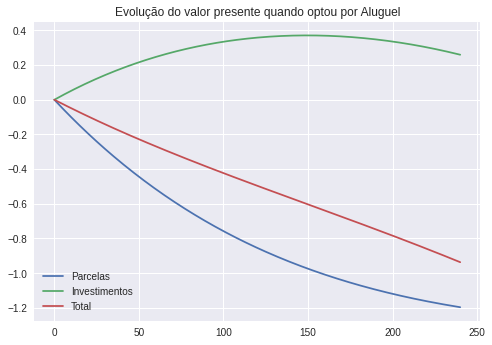

In [200]:
al = Aluguel(V=1, c_a=0.005, t_r=0.05, t_i=0.05, t_m=0.10, amortizador=SAC(t_j=0.078, n=20*12))
VP_parcelas, VP_investimentos, VP_total = al.run_simulation()
plt.plot(VP_parcelas, label='Parcelas')
plt.plot(VP_investimentos, label='Investimentos')
plt.plot(VP_total, label='Total')
plt.legend()
plt.title('Evolução do valor presente quando optou por Aluguel');

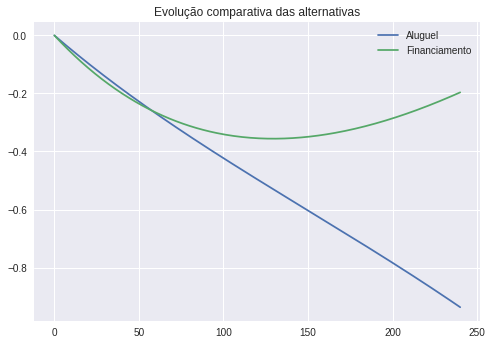

In [203]:
V = 1
c_a=0.005
t_i=0.094
t_m = 0.1
amort = SAC(t_j=0.078, n=20*12)

al = Aluguel(V=1, c_a=0.005, t_r=0.05, t_i=0.05, t_m=0.10, amortizador=SAC(t_j=0.078, n=20*12))
al_parcelas, al_investimentos, al_total = al.run_simulation()

f = Financiamento(V=1, t_r=0.05, t_i=0.05, amortizador=SAC(t_j=0.078, n=12*20))
f_parcelas, f_imovel, f_total = f.run_simulation()

plt.plot(al_total, label='Aluguel')
plt.plot(f_total, label='Financiamento')
plt.legend()
plt.title('Evolução comparativa das alternativas');